In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2.0],
    c2 = [0.5, 2.0],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = l2_regularizer,
    mask = True))

see one see two 2.0 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 200
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 10
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 10, Accuracy: 0.8641975308641975, Loss: 0.6453784660056785
Checkpoint 20, Accuracy: 0.8518518518518519, Loss: 0.6440399311206959
Checkpoint 30, Accuracy: 0.8827160493827161, Loss: 0.6354427337646484
Checkpoint 40, Accuracy: 0.8703703703703703, Loss: 0.5277012012622975
Checkpoint 50, Accuracy: 0.8641975308641975, Loss: 0.5823592786435727
Checkpoint 60, Accuracy: 0.8518518518518519, Loss: 0.5727382942482278
Checkpoint 70, Accuracy: 0.8580246913580247, Loss: 0.5753603334780093
Checkpoint 80, Accuracy: 0.8888888888888888, Loss: 0.4547910690307617
Checkpoint 90, Accuracy: 0.9259259259259259, Loss: 0.44309492464418765
Checkpoint 100, Accuracy: 0.9382716049382716, Loss: 0.40442996554904515
Checkpoint 110, Accuracy: 0.9259259259259259, Loss: 0.38511756614402487
Checkpoint 120, Accuracy: 0.9382716049382716, Loss: 0.35235422628897206
Checkpoint 130, Accuracy: 0.9382716049382716, Loss: 0.3509910018355758
Checkpoint 140, Accuracy: 0.9444444444444444, Loss: 0.3469175409387659
Checkpoint 

In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

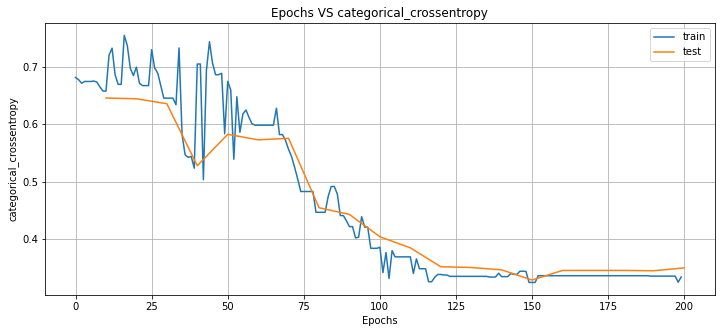

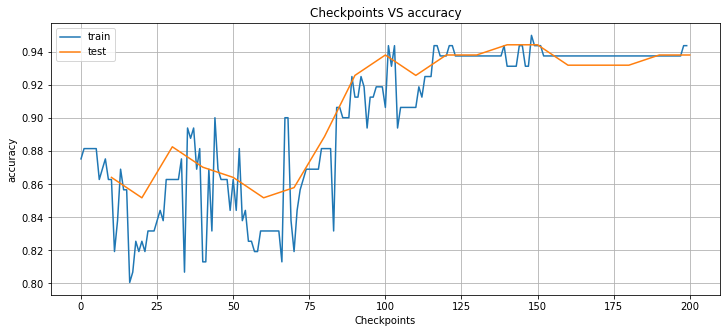

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [12]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.783607   0.03784731 0.17854565]
[1. 0. 0.] <-> [0.8163034  0.06789828 0.11579829]
[1. 0. 0.] <-> [0.7691469  0.16264275 0.0682103 ]
[1. 0. 0.] <-> [0.6597484  0.29653624 0.04371535]
[1. 0. 0.] <-> [0.80074257 0.11443916 0.08481824]
[0. 1. 0.] <-> [0.24526846 0.7453122  0.00941933]
[0. 1. 0.] <-> [0.6255147  0.33228692 0.04219835]
[1. 0. 0.] <-> [0.78952944 0.03866537 0.17180519]
[0. 1. 0.] <-> [0.5040466  0.43153962 0.0644138 ]
[0. 1. 0.] <-> [0.29747885 0.6899461  0.01257496]
[0. 1. 0.] <-> [0.5855734  0.3810878  0.03333881]
[1. 0. 0.] <-> [0.7488912  0.16219148 0.08891732]
[1. 0. 0.] <-> [0.85130614 0.04890693 0.09978692]
[1. 0. 0.] <-> [0.8153952  0.0377142  0.14689067]
[1. 0. 0.] <-> [0.83761317 0.0655143  0.09687247]
[0. 0. 1.] <-> [0.30584157 0.01068625 0.68347216]
[1. 0. 0.] <-> [0.75665593 0.04733844 0.19600563]
[0. 1. 0.] <-> [0.2414648  0.7497559  0.00877934]
[1. 0. 0.] <-> [0.84375685 0.0387193  0.11752383]
[0. 1. 0.] <-> [0.3550558  0.6275367  0.01740752]


In [13]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8641975308641975, 'mean_square_error': 0.31888122387057855, 'categorical_crossentropy': 0.6453784660056785, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 14, 'tn_hit': 18, 'fn_hit': 4}, 1: {'tp_hit': 13, 'fp_hit': 8, 'tn_hit': 83, 'fn_hit': 4}, 2: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 14}}, 'checkpoint': 10} 


{'accuracy': 0.8518518518518519, 'mean_square_error': 0.35763415027945195, 'categorical_crossentropy': 0.6440399311206959, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 12, 'tn_hit': 20, 'fn_hit': 2}, 1: {'tp_hit': 9, 'fp_hit': 12, 'tn_hit': 79, 'fn_hit': 8}, 2: {'tp_hit': 1, 'fp_hit': 0, 'tn_hit': 93, 'fn_hit': 14}}, 'checkpoint': 20} 


{'accuracy': 0.8827160493827161, 'mean_square_error': 0.3651069368466289, 'categorical_crossentropy': 0.6354427337646484, 'essential_metrics': {0: {'tp_hit': 74, 'fp_hit': 14, 'tn_hit': 18, 'fn_hit': 2}, 1: {'tp_hit': 7, 'fp_hit': 4, 'tn_hit': 87, 'fn_hit': 10}, 2: {'tp_hit': 8, 'fp_hit': 1, 'tn_hit': 92, 'fn

In [14]:
print(model)

Layer 1
Neuron 0: weights:
[-0.5687      0.86890465  0.2595719  -0.20429276 -0.3447494 ]
 bias: -0.0904400572180748

Neuron 1: weights:
[ 0.10725299 -0.6618771  -0.19865371  0.6507526   0.6333496 ]
 bias: -0.41502052545547485

Neuron 2: weights:
[ 0.3490814  -1.4696348  -0.82640606 -0.24407005 -0.08025487]
 bias: 0.8728925585746765

Neuron 3: weights:
[-0.6420858   0.649069   -0.0707633  -0.39933828 -0.63118553]
 bias: 0.624613881111145

$
Layer 2
Neuron 0: weights:
[-0.22369358 -0.42209664  1.4740433   0.6294382 ]
 bias: -0.0024629374966025352

Neuron 1: weights:
[ 1.1177157  -0.7531699  -2.005625    0.34622595]
 bias: 0.08486879616975784

Neuron 2: weights:
[-1.3358175  1.3467743  0.5061667 -1.5546646]
 bias: -0.06768707185983658

$

